In [3]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from scipy import stats
import seaborn as sns
import numpy as np
import pandas as pd
#Plotting and Visualizations
import matplotlib.pyplot as plt
%matplotlib inline
# statistics
# time series analysis


In [4]:
df = pd.read_csv('train.csv', parse_dates=True,
                 low_memory=False, index_col='Date')
df.head()


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2022-07-31,1,5,5263,555,1,1,0,1
2022-07-31,2,5,6064,625,1,1,0,1
2022-07-31,3,5,8314,821,1,1,0,1
2022-07-31,4,5,13995,1498,1,1,0,1
2022-07-31,5,5,4822,559,1,1,0,1


In [5]:
df.describe()


,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00


We are dealing with time series data so it will probably serve us to extract dates for further analysis. We also have two likely correlated vaiables in the dataset, which can be combined into a new feature.


In [6]:
# data extraction

df['Year'] = df.index.year
df['Month'] = df.index.month
df['Day'] = df.index.day
df['WeekOfYear'] = df.index.isocalendar().week
df.head()


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear
Date,,,,,,,,,,,,
2022-07-31,1,5,5263,555,1,1,0,1,2022,7,31,30
2022-07-31,2,5,6064,625,1,1,0,1,2022,7,31,30
2022-07-31,3,5,8314,821,1,1,0,1,2022,7,31,30
2022-07-31,4,5,13995,1498,1,1,0,1,2022,7,31,30
2022-07-31,5,5,4822,559,1,1,0,1,2022,7,31,30


In [7]:
df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1017209 entries, 2022-07-31 to 2020-01-01
Data columns (total 12 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Sales          1017209 non-null  int64 
 3   Customers      1017209 non-null  int64 
 4   Open           1017209 non-null  int64 
 5   Promo          1017209 non-null  int64 
 6   StateHoliday   1017209 non-null  object
 7   SchoolHoliday  1017209 non-null  int64 
 8   Year           1017209 non-null  int64 
 9   Month          1017209 non-null  int64 
 10  Day            1017209 non-null  int64 
 11  WeekOfYear     1017209 non-null  UInt32
dtypes: UInt32(1), int64(10), object(1)
memory usage: 98.0+ MB


In [8]:
# adding new variable

df['SalePerCustomer'] = df['Sales']/df['Customers']
df['SalePerCustomer'].describe()


count    844340.000000
mean          9.493619
std           2.197494
min           0.000000
25%           7.895563
50%           9.250000
75%          10.899729
max          64.957854
Name: SalePerCustomer, dtype: float64

In this section we go through the train and store data, handle missing values and create new features for further analysis.


In [9]:
df.isnull().sum()


Store                   0
DayOfWeek               0
Sales                   0
Customers               0
Open                    0
Promo                   0
StateHoliday            0
SchoolHoliday           0
Year                    0
Month                   0
Day                     0
WeekOfYear              0
SalePerCustomer    172869
dtype: int64

In [10]:
df.fillna(0, inplace=True)


Missing values

Closed stores and zero sales stores


In [11]:
# closed stores
df[(df.Open == 0) & (df.Sales == 0)]


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
Date,,,,,,,,,,,,,
2022-07-31,292,5,0,0,0,1,0,1,2022,7,31,30,0.0
2022-07-31,876,5,0,0,0,1,0,1,2022,7,31,30,0.0
2022-07-30,292,4,0,0,0,1,0,1,2022,7,30,30,0.0
2022-07-30,876,4,0,0,0,1,0,1,2022,7,30,30,0.0
2022-07-29,292,3,0,0,0,1,0,1,2022,7,29,30,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-01,1111,2,0,0,0,0,a,1,2020,1,1,1,0.0
2020-01-01,1112,2,0,0,0,0,a,1,2020,1,1,1,0.0
2020-01-01,1113,2,0,0,0,0,a,1,2020,1,1,1,0.0


There're 172817 closed stores in the data. It is about 10% of the total amount of observations. To avoid any biased forecasts we will drop these values.


In [12]:
# opened stores with zero sales
zero_sales = df[(df.Open != 0) & (df.Sales == 0)]
print("In total: ", zero_sales.shape)
zero_sales.head()


In total:  (54, 13)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
Date,,,,,,,,,,,,,
2022-05-15,971,5,0,0,1,0,0,1,2022,5,15,19,0.0
2022-03-26,674,4,0,0,1,0,0,0,2022,3,26,12,0.0
2022-02-05,699,4,0,0,1,1,0,0,2022,2,5,5,0.0
2021-10-01,708,3,0,0,1,1,0,0,2021,10,1,39,0.0
2021-09-22,357,1,0,0,1,0,0,0,2021,9,22,38,0.0


In [13]:
df = df[(df["Open"] != 0) & (df['Sales'] != 0)]
df.head()


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
Date,,,,,,,,,,,,,
2022-07-31,1,5,5263,555,1,1,0,1,2022,7,31,30,9.482883
2022-07-31,2,5,6064,625,1,1,0,1,2022,7,31,30,9.702400
2022-07-31,3,5,8314,821,1,1,0,1,2022,7,31,30,10.126675
2022-07-31,4,5,13995,1498,1,1,0,1,2022,7,31,30,9.342457
2022-07-31,5,5,4822,559,1,1,0,1,2022,7,31,30,8.626118


Text(0.5, 1.0, 'Sales vs Month')

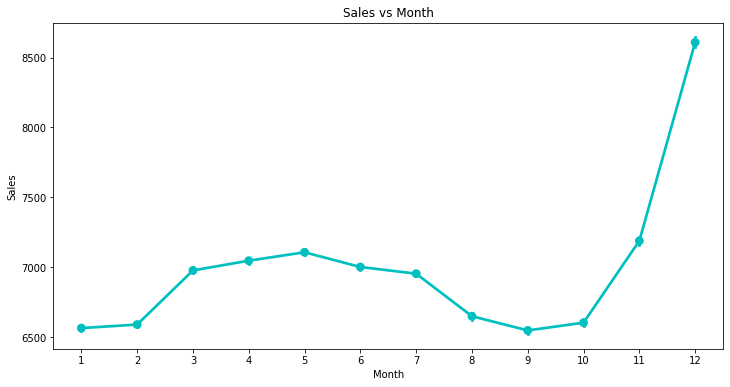

In [14]:
plt.rcParams["figure.figsize"] = (12, 6)
sns.pointplot(data=df, x="Month", y="Sales", color="c")
plt.title("Sales vs Month")


Text(0.5, 1.0, 'Customers vs Month')

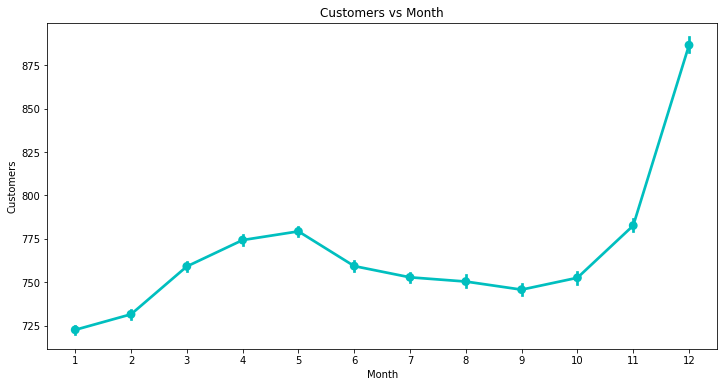

In [15]:
sns.pointplot(data=df, x="Month", y="Customers", color="c")
plt.title("Customers vs Month")


Text(0.5, 1.0, 'Sales per Customer vs Month')

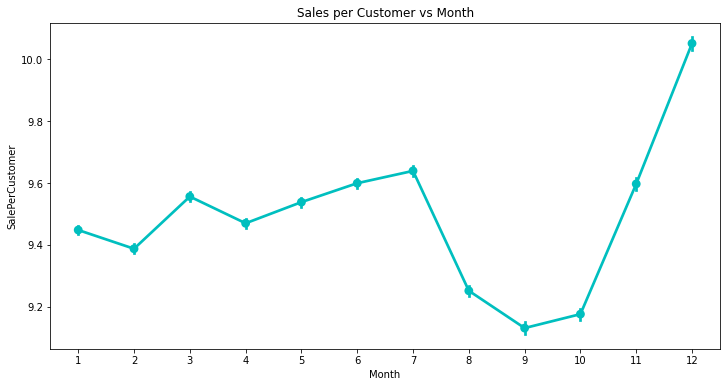

In [16]:
sns.pointplot(data=df, x="Month", y="SalePerCustomer", color="c")
plt.title("Sales per Customer vs Month")


## Time Series Analysis


Separating Sales from the dataframe.
Grouping and Aggregating sales based on Date and considering their mean


In [17]:
sales_df = df['Sales'] * 1.0
sales_df = sales_df.groupby('Date').mean()
sales_df.head()


Date
2020-01-01    5719.705882
2020-01-02    6255.471647
2020-01-03    5723.913436
2020-01-04    5991.835740
2020-01-05    5376.326107
Name: Sales, dtype: float64

Resampling data from Days to Weeks to see trends more clearly


<AxesSubplot:xlabel='Date'>

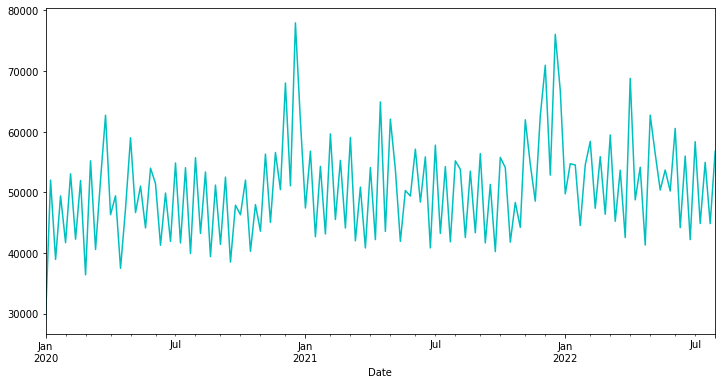

In [18]:
sales_df.resample('W').sum().plot(color='c')


### Yearly Trend


<AxesSubplot:xlabel='Date'>

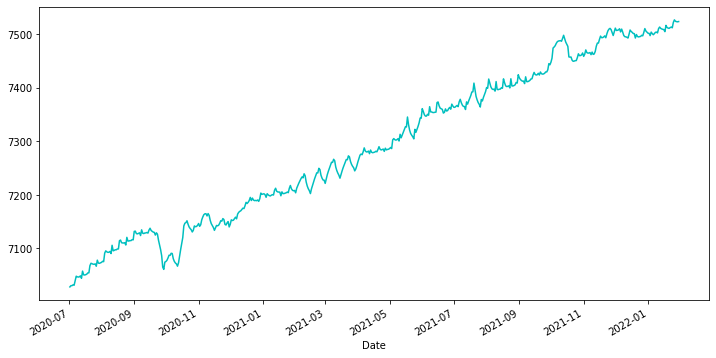

In [19]:
decomposition = seasonal_decompose(sales_df, model='additive', period=365)
decomposition.trend.plot(color='c')


### Plotting the ACF and PACF charts to find the optimal parameters


c:\Users\Anurag\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


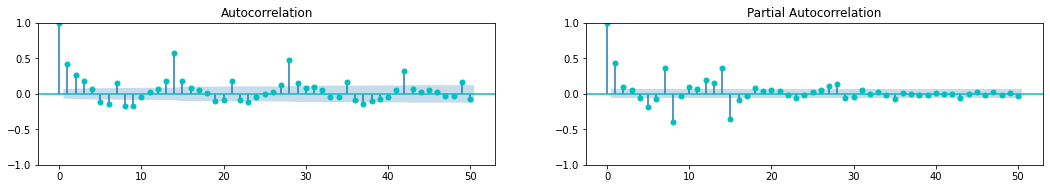

In [22]:
plt.figure(figsize=(18, 12))

# acf and pacf
plt.subplot(421)
plot_acf(sales_df, lags=50, ax=plt.gca(), color='c')
plt.subplot(422)
plot_pacf(sales_df, lags=50, ax=plt.gca(), color='c')
plt.show()


In [24]:
from scipy import stats
from scipy.stats import normaltest


def residual_plot(model):

    resid = model.resid
    print(normaltest(resid))
    # returns a 2-tuple of the chi-squared statistic, and the associated p-value. the p-value is very small, meaning
    # the residual is not a normal distribution

    fig = plt.figure(figsize=(12, 8))
    ax0 = fig.add_subplot(111)

    sns.distplot(resid, fit=stats.norm, ax=ax0)  # need to import scipy.stats

    # Get the fitted parameters used by the function
    (mu, sigma) = stats.norm.fit(resid)

    # Now plot the distribution using
    plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(
        mu, sigma)], loc='best')
    plt.ylabel('Frequency')
    plt.title('Residual distribution')

    # ACF and PACF
    fig = plt.figure(figsize=(12, 8))
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(model.resid, lags=40, ax=ax1)
    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(model.resid, lags=40, ax=ax2)


Importing Test dates


In [25]:
test_df = pd.read_csv('test.csv', parse_dates=True)
test_df = test_df.sort_values(by='Date')
test_df['Date'] = pd.DatetimeIndex(test_df['Date']).to_period('D')
test_dates = test_df['Date'].unique()
test_dates


<PeriodArray>
['2022-08-01', '2022-08-02', '2022-08-03', '2022-08-04', '2022-08-05',
 '2022-08-06', '2022-08-07', '2022-08-08', '2022-08-09', '2022-08-10',
 '2022-08-11', '2022-08-12', '2022-08-13', '2022-08-14', '2022-08-15',
 '2022-08-16', '2022-08-17', '2022-08-18', '2022-08-19', '2022-08-20',
 '2022-08-21', '2022-08-22', '2022-08-23', '2022-08-24', '2022-08-25',
 '2022-08-26', '2022-08-27', '2022-08-28', '2022-08-29', '2022-08-30',
 '2022-08-31', '2022-09-01', '2022-09-02', '2022-09-03', '2022-09-04',
 '2022-09-05', '2022-09-06', '2022-09-07', '2022-09-08', '2022-09-09',
 '2022-09-10', '2022-09-11', '2022-09-12', '2022-09-13', '2022-09-14',
 '2022-09-15', '2022-09-16', '2022-09-17']
Length: 48, dtype: period[D]

In [26]:
sales_df.index = pd.DatetimeIndex(sales_df.index).to_period('D')
sales_df.head()


Date
2020-01-01    5719.705882
2020-01-02    6255.471647
2020-01-03    5723.913436
2020-01-04    5991.835740
2020-01-05    5376.326107
Freq: D, Name: Sales, dtype: float64

### ARIMA


In [27]:
arima_model = ARIMA(endog=sales_df, order=(11, 1, 1)).fit()
arima_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Sales   No. Observations:                  942
Model:                ARIMA(11, 1, 1)   Log Likelihood               -8080.483
Date:                Thu, 01 Dec 2022   AIC                          16186.966
Time:                        12:55:08   BIC                          16249.976
Sample:                    01-01-2020   HQIC                         16210.985
                         - 07-31-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0729      0.074      0.992      0.321      -0.071       0.217
ar.L2         -0.0947      0.049     -1.925      0.054      -0.191       0.002
ar.L3         -0.1451      0.041     -3.557      0.000      -0.225      -0.065
ar.L4         -0.0941      0.040     -2.358      0.018      -0.172      -0.016
ar.L5         -0.3114      0.042     -7.441      0.000      -0.393      -0.229
ar.L6         -0.3233      0.038     -8.477      0.000      -0.398      -0.249
ar.L7          0.2878      0.040      7.258      0.000       0.210       0.365
ar.L8         -0.3575      0.031    -11.381      0.000      -0.419      -0.296
ar.L9         -0.2224      0.037     -5.965      0.000      -0.295      -0.149
ar.L10        -0.1411      0.042     -3.371      0.001      -0.223      -0.059
ar.L11        -0.2079      0.048     -4.334      0.000      -0.302      -0.114
ma.L1         -0.5920      0.066     -8.903      0.000      -0.722      -0.462
sigma2      1.768e+06      7e+04     25.247      0.000    1.63e+06    1.91e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):               128.37
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):               1.44   Skew:                             0.43
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

NormaltestResult(statistic=80.88995182292447, pvalue=2.7225141205703763e-18)


c:\Users\Anurag\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\Anurag\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


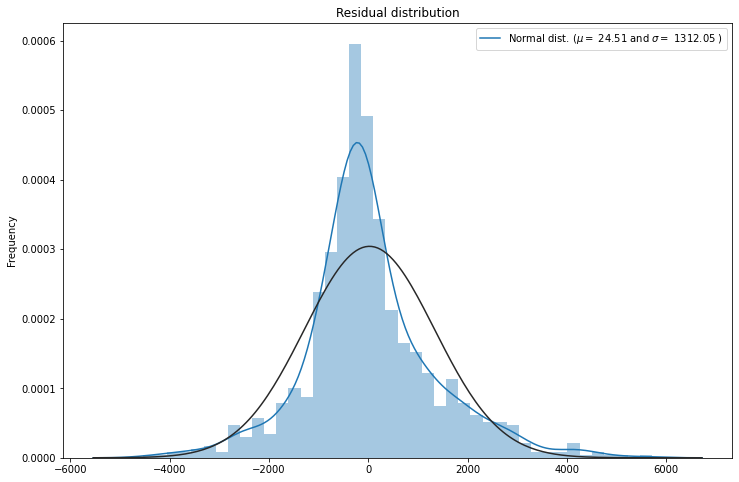

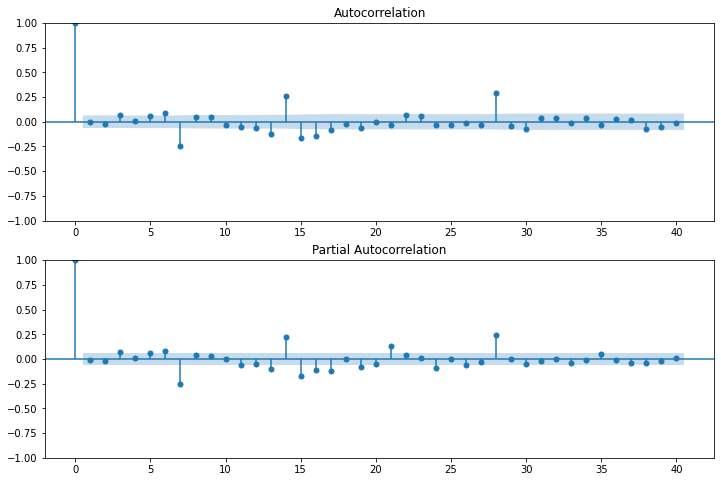

In [28]:
residual_plot(arima_model)


<AxesSubplot:xlabel='Date'>

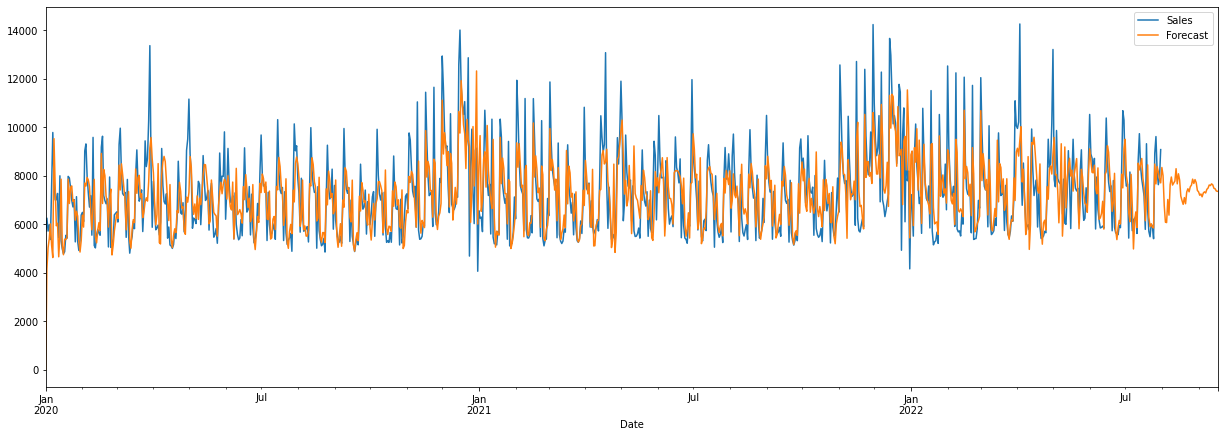

In [29]:
arima_df = pd.DataFrame(sales_df)
arima_df['Forecast'] = arima_model.fittedvalues
forecast_df = pd.DataFrame(data=arima_model.predict(
    start=test_dates[0], end=test_dates[-1]))
forecast_df = forecast_df.reset_index().rename(
    columns={'index': 'Date', 'predicted_mean': 'Forecast'}).set_index('Date')
arima_df = pd.concat([arima_df, forecast_df])
arima_df.plot(figsize=(21, 7))


Text(0, 0.5, 'Sales')

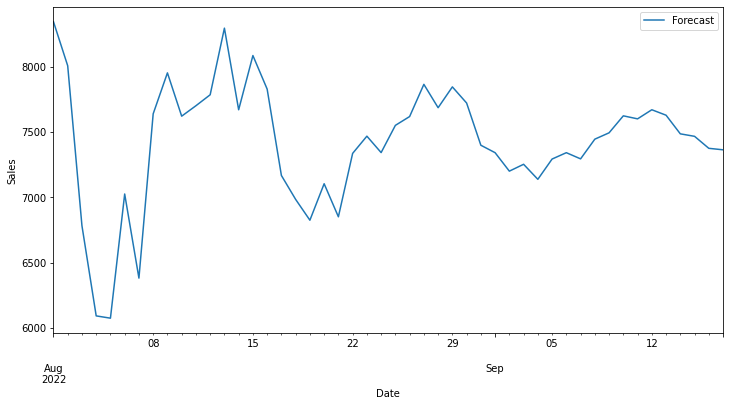

In [30]:
forecast_df.plot()
plt.ylabel('Sales')


In [31]:
arima_rmse = mean_squared_error(
    sales_df.values, arima_model.fittedvalues, squared=False)
print(f'Arima Root Mean Squared Error: {arima_rmse}')


Arima Root Mean Squared Error: 1312.2764437315632


### SARIMA


In [32]:
sarima_model = SARIMAX(sales_df, trend='n', order=(11, 1, 1), seasonal_order=(0, 1, 0, 12), enforce_stationarity=False,
                       enforce_invertibility=False).fit()
sarima_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                Sales   No. Observations:                  942
Model:             SARIMAX(11, 1, 1)x(0, 1, [], 12)   Log Likelihood               -8150.641
Date:                              Thu, 01 Dec 2022   AIC                          16327.282
Time:                                      12:55:24   BIC                          16389.970
Sample:                                  01-01-2020   HQIC                         16351.206
                                       - 07-31-2022                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5078      0.039     13.060      0.000       0.432       0.584
ar.L2         -0.1443      0.042     -3.421      0.001      -0.227      -0.062
ar.L3          0.1145      0.049      2.346      0.019       0.019       0.210
ar.L4          0.0102      0.046      0.224      0.823      -0.079       0.099
ar.L5         -0.1914      0.036     -5.254      0.000      -0.263      -0.120
ar.L6         -0.0745      0.038     -1.964      0.050      -0.149      -0.000
ar.L7          0.4695      0.037     12.552      0.000       0.396       0.543
ar.L8         -0.3985      0.042     -9.546      0.000      -0.480      -0.317
ar.L9         -0.0294      0.043     -0.690      0.490      -0.113       0.054
ar.L10        -0.0887      0.046     -1.945      0.052      -0.178       0.001
ar.L11        -0.0868      0.044     -1.969      0.049      -0.173      -0.000
ma.L1         -0.9993      0.030    -33.353      0.000      -1.058      -0.941
sigma2      3.567e+06   2.26e+05     15.809      0.000    3.12e+06    4.01e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.21   Jarque-Bera (JB):                 1.33
Prob(Q):                              0.64   Prob(JB):                         0.51
Heteroskedasticity (H):               1.51   Skew:                            -0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

NormaltestResult(statistic=2.1710696876458417, pvalue=0.3377211095328982)


c:\Users\Anurag\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\Anurag\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


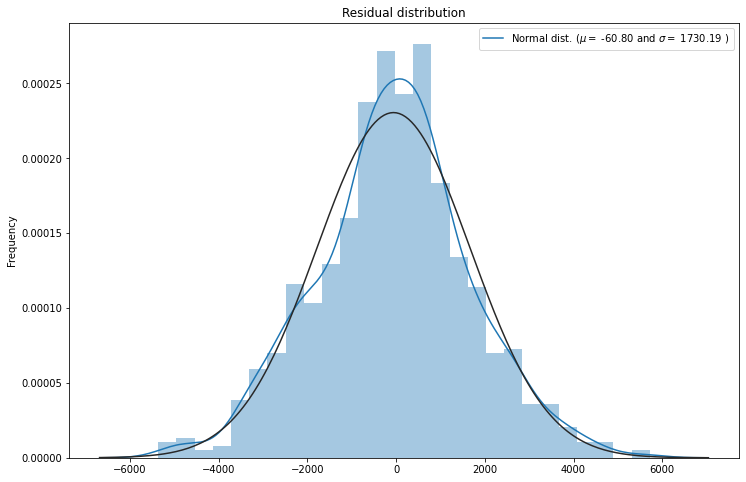

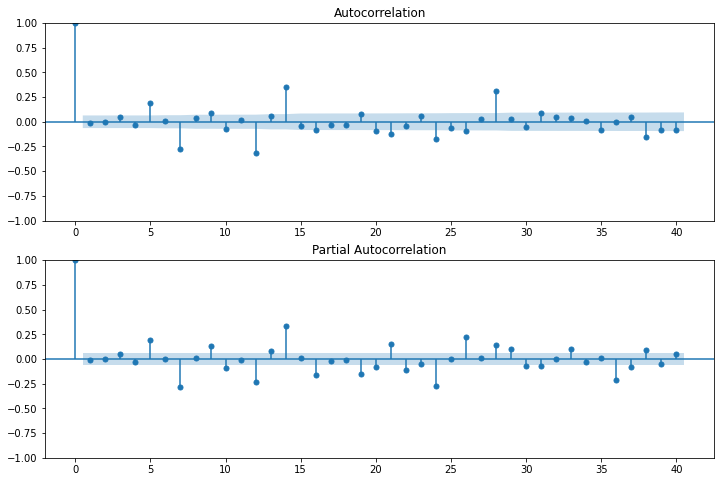

In [33]:
residual_plot(sarima_model)


<AxesSubplot:xlabel='Date'>

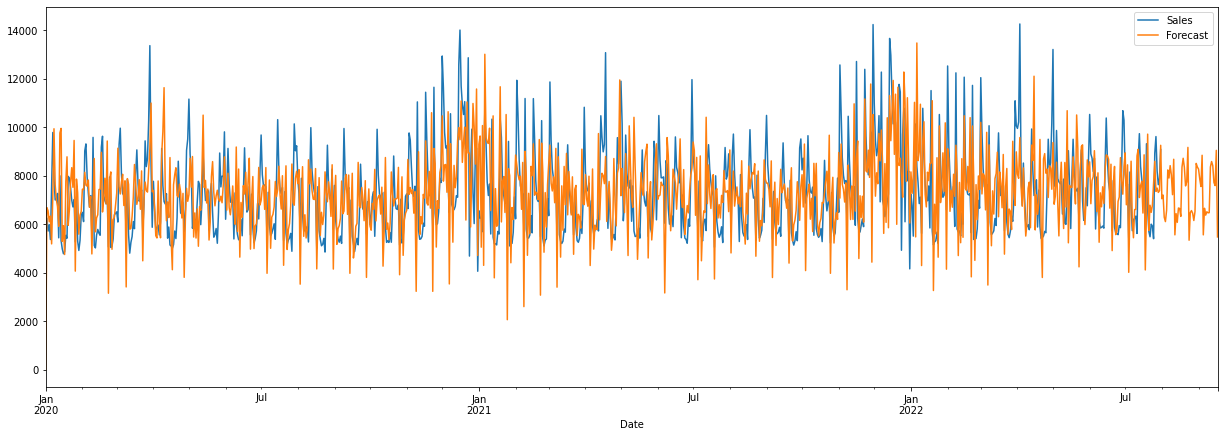

In [34]:
sarima_df = pd.DataFrame(sales_df)
sarima_df['Forecast'] = sarima_model.fittedvalues
forecast_df = pd.DataFrame(data=sarima_model.predict(
    start=test_dates[0], end=test_dates[-1]))
forecast_df = forecast_df.reset_index().rename(
    columns={'index': 'Date', 'predicted_mean': 'Forecast'}).set_index('Date')
sarima_df = pd.concat([sarima_df, forecast_df])
sarima_df.plot(figsize=(21, 7))


Text(0, 0.5, 'Sales')

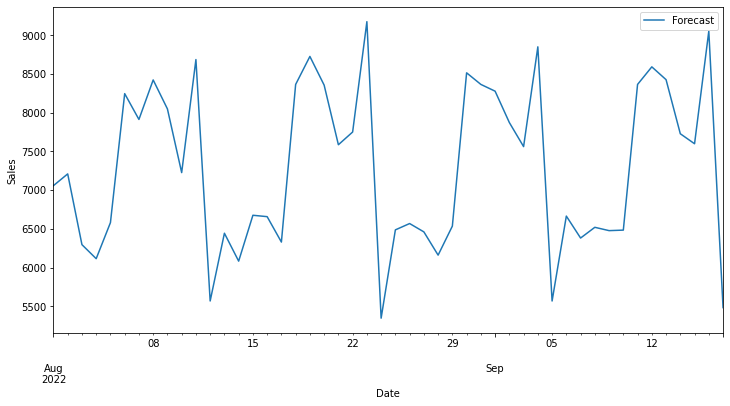

In [35]:
forecast_df.plot()
plt.ylabel('Sales')


In [36]:
sarima_rmse = mean_squared_error(
    sales_df.values, sarima_model.fittedvalues, squared=False)
print(f'Arima Root Mean Squared Error: {sarima_rmse}')


Arima Root Mean Squared Error: 1731.2625703348974


### Holt Winter Exponential Smoothing


In [37]:
x = 12
alpha = 1/(2*x)


In [38]:
hw_df = sales_df.copy()
hw_df = hw_df.reset_index().set_index('Date')
hw_df.head()


,Sales
Date,
2020-01-01,5719.705882
2020-01-02,6255.471647
2020-01-03,5723.913436
2020-01-04,5991.835740
2020-01-05,5376.326107


In [39]:
hw_df['HWES1'] = SimpleExpSmoothing(hw_df["Sales"]).fit(
    smoothing_level=alpha, optimized=False, use_brute=True).fittedvalues
hw_df.head()


,Sales,HWES1
Date,,
2020-01-01,5719.705882,5719.705882
2020-01-02,6255.471647,5719.705882
2020-01-03,5723.913436,5742.029456
2020-01-04,5991.835740,5741.274622
2020-01-05,5376.326107,5751.714668


<AxesSubplot:title={'center':'Holt Winters Single Exponential Smoothing graph'}, xlabel='Date'>

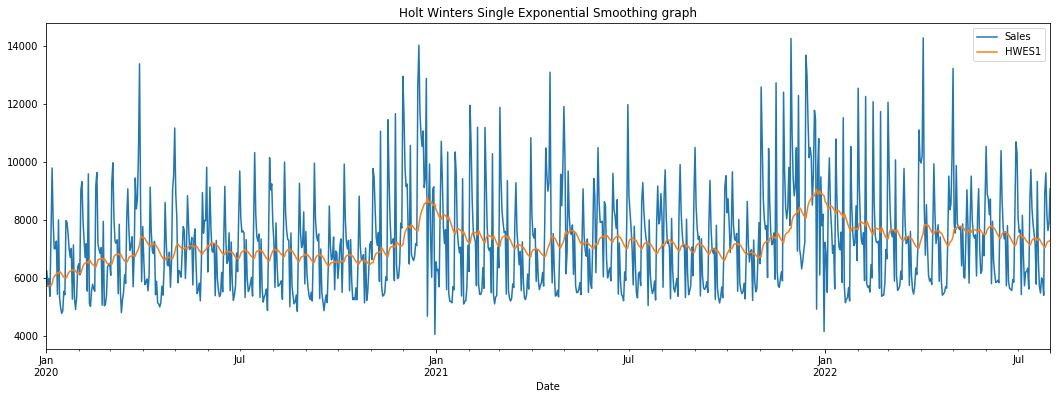

In [40]:
hw_df[['Sales', 'HWES1']].plot(
    title='Holt Winters Single Exponential Smoothing graph', figsize=(18, 6))


c:\Users\Anurag\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\Anurag\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


<AxesSubplot:title={'center':'Holt Winters graph: Multiplicative Trend'}, xlabel='Date'>

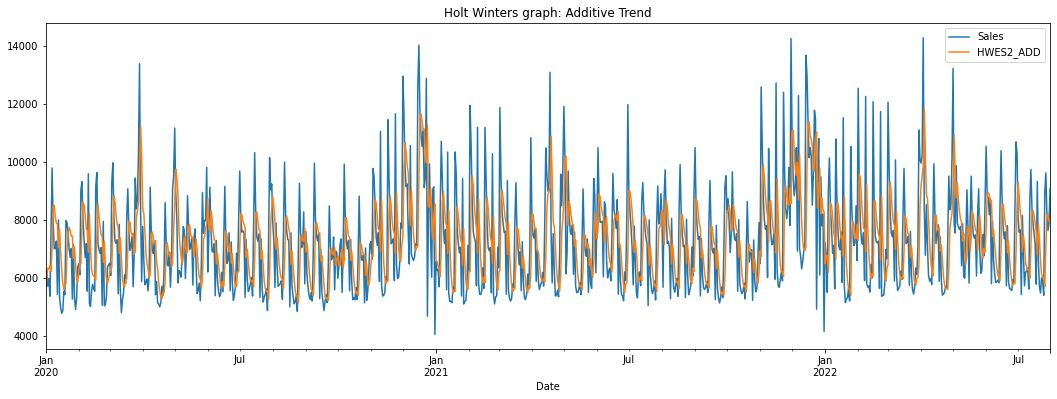

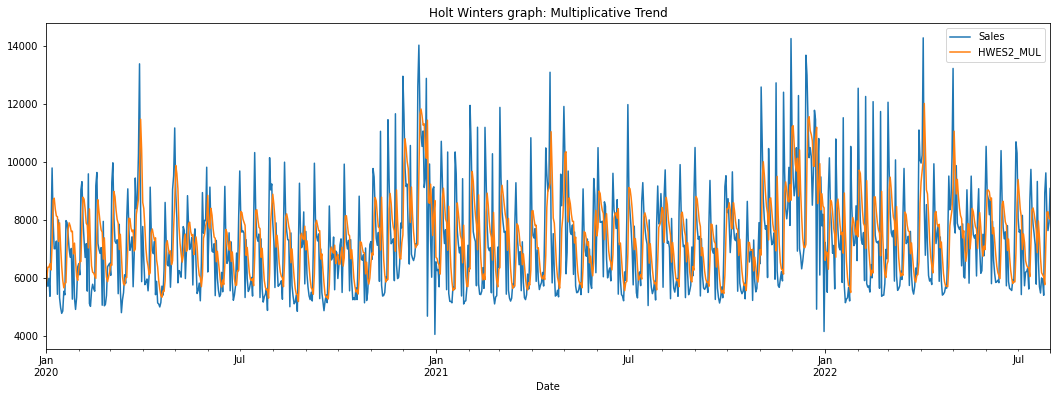

In [41]:
hw_df['HWES2_ADD'] = ExponentialSmoothing(
    hw_df['Sales'], trend='add').fit().fittedvalues
hw_df['HWES2_MUL'] = ExponentialSmoothing(
    hw_df['Sales'], trend='mul').fit().fittedvalues
hw_df[['Sales', 'HWES2_ADD']].plot(
    title='Holt Winters graph: Additive Trend', figsize=(18, 6))
hw_df[['Sales', 'HWES2_MUL']].plot(
    title='Holt Winters graph: Multiplicative Trend', figsize=(18, 6))


In [42]:
hw_model = ExponentialSmoothing(
    hw_df['Sales'], trend='add', seasonal='add', seasonal_periods=365).fit()


c:\Users\Anurag\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [43]:
forecast_df = pd.DataFrame(data=hw_model.predict(
    start=test_dates[0], end=test_dates[-1]))
forecast_df = forecast_df.reset_index().rename(
    columns={'index': 'Date', 0: 'Forecast'}).set_index('Date')


<AxesSubplot:xlabel='Date'>

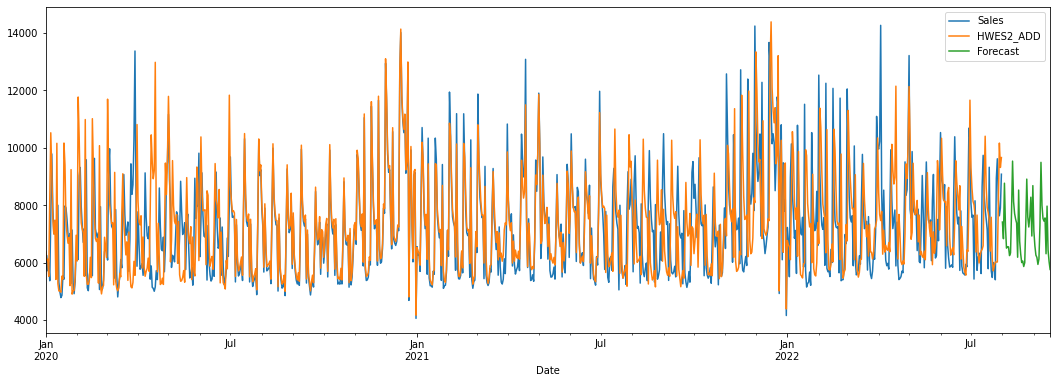

In [44]:
final_df = pd.concat([hw_df, forecast_df])
final_df = final_df.rename(columns={0: 'Sales'})
final_df["HWES2_ADD"] = hw_model.fittedvalues
final_df[["Sales", "HWES2_ADD", "Forecast"]].plot(figsize=(18, 6))


Text(0, 0.5, 'Sales')

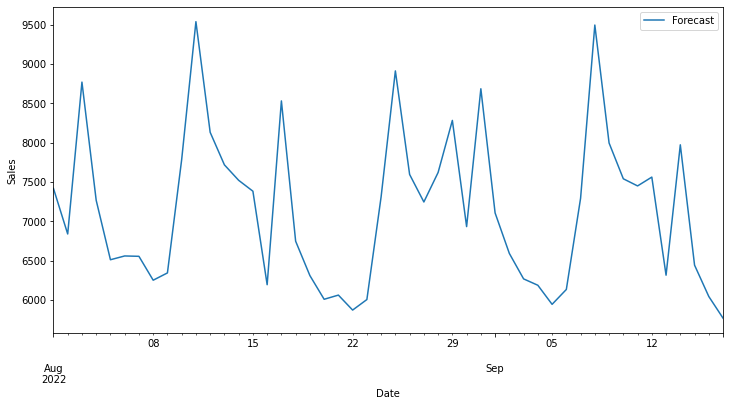

In [45]:
forecast_df.plot()
plt.ylabel('Sales')


In [46]:
hw_rmse = mean_squared_error(
    sales_df.values, hw_model.fittedvalues, squared=False)
print(f'Holt Winter Root Mean Squared Error: {hw_rmse}')


Holt Winter Root Mean Squared Error: 1649.7714025443115


### Dynamic Regression

Trying Dynmaic Regression with Daily Sales as dependent variable and Promo as an independent variable


In [79]:
from pybats.loss_functions import MAPE
from pybats.analysis import analysis
from pybats.point_forecast import median
from pybats.plot import plot_data_forecast
import datetime


In [80]:
reg_df = df.groupby('Date').mean()
reg_df.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
Date,,,,,,,,,,,,
2020-01-01,529.058824,2.0,5719.705882,1146.529412,1.0,0.0,1.000000,2020.0,1.0,1.0,1.0,4.989809
2020-01-02,557.943294,3.0,6255.471647,750.742574,1.0,0.0,1.000000,2020.0,1.0,2.0,1.0,8.738103
2020-01-03,558.138864,4.0,5723.913436,686.239856,1.0,0.0,0.932372,2020.0,1.0,3.0,1.0,8.755473
2020-01-04,558.180505,5.0,5991.835740,705.899819,1.0,0.0,0.932310,2020.0,1.0,4.0,1.0,8.861041
2020-01-05,558.217706,6.0,5376.326107,621.022584,1.0,0.0,0.100271,2020.0,1.0,5.0,1.0,9.007924


Text(0, 0.5, 'Sales')

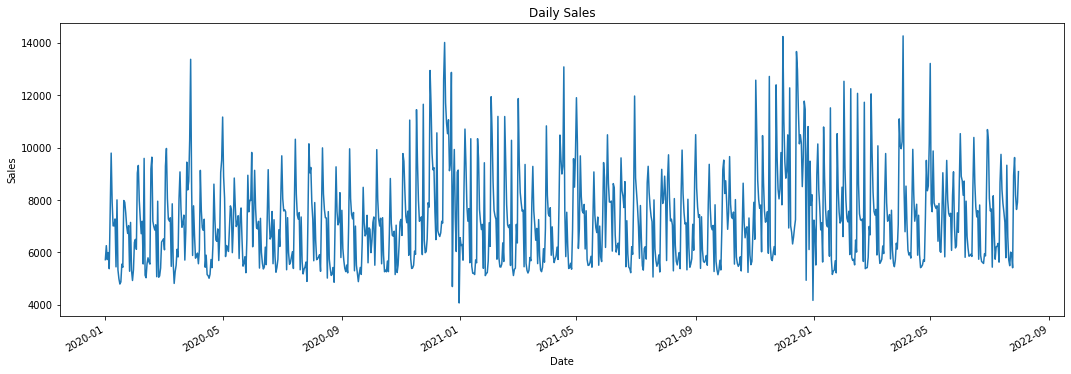

In [81]:
reg_df['Sales'].plot(figsize=(18, 6))
plt.title('Daily Sales')
plt.ylabel('Sales')

Text(0, 0.5, 'Customers')

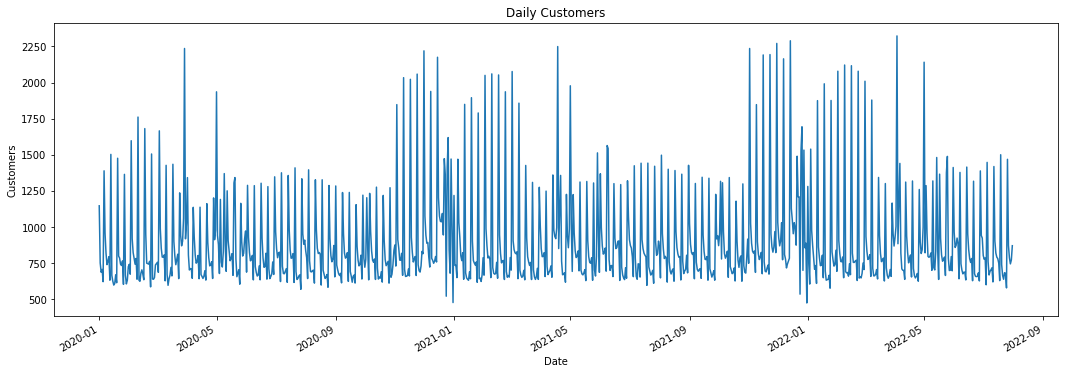

In [82]:
reg_df['Customers'].plot(figsize=(18, 6))
plt.title('Daily Customers')
plt.ylabel('Customers')


Text(0, 0.5, 'Promo')

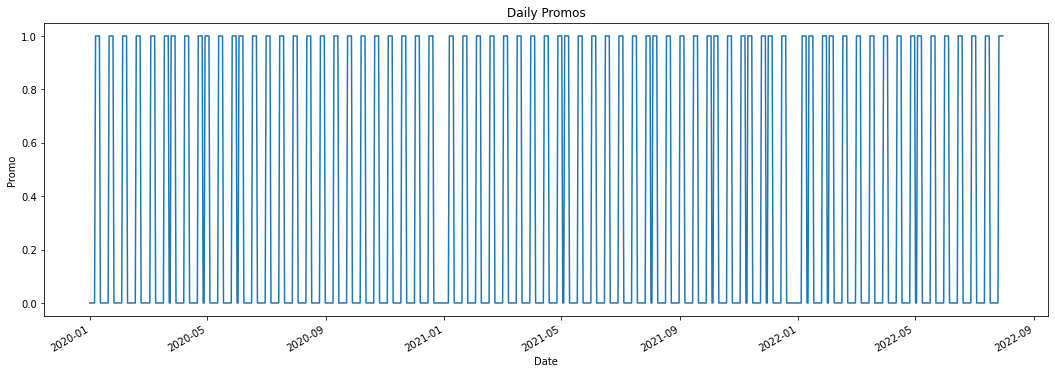

In [83]:
reg_df['Promo'].plot(figsize=(18, 6))
plt.title('Daily Promos')
plt.ylabel('Promo')


In [84]:
def bayes_forecast(iv, dv):
    if iv is None:
        x = None
    else:
        x = iv.values

    y = dv.values

    k = 1
    forecast_start = 0
    forecast_end = len(y) - 1

    mod, samples = analysis(Y=y,
                            X=x,
                            family='poisson',
                            forecast_start=forecast_start,
                            forecast_end=forecast_end,
                            k=k,
                            nsamps=2000,
                            seasPeriods=[365],
                            seasHarmComponents=[
                                [1, 2]],
                            prior_length=28,
                            deltrend=0.94,
                            delregn=0.90,
                            delVar=0.98,
                            delSeas=0.98,
                            rho=.5,
                            )
    forecast = median(samples)

    print("MAPE:", MAPE(y[-18:], forecast[-18:]).round(2))
    return mod, forecast, samples, y


In [85]:
mv_mod, mv_for, mv_samp, mv_y = bayes_forecast(reg_df['Promo'], reg_df['Sales'])

MAPE: 13.1


In [86]:
uv_mod, uv_for, uv_samp, uv_y = bayes_forecast(None, reg_df['Sales'])

MAPE: 13.28


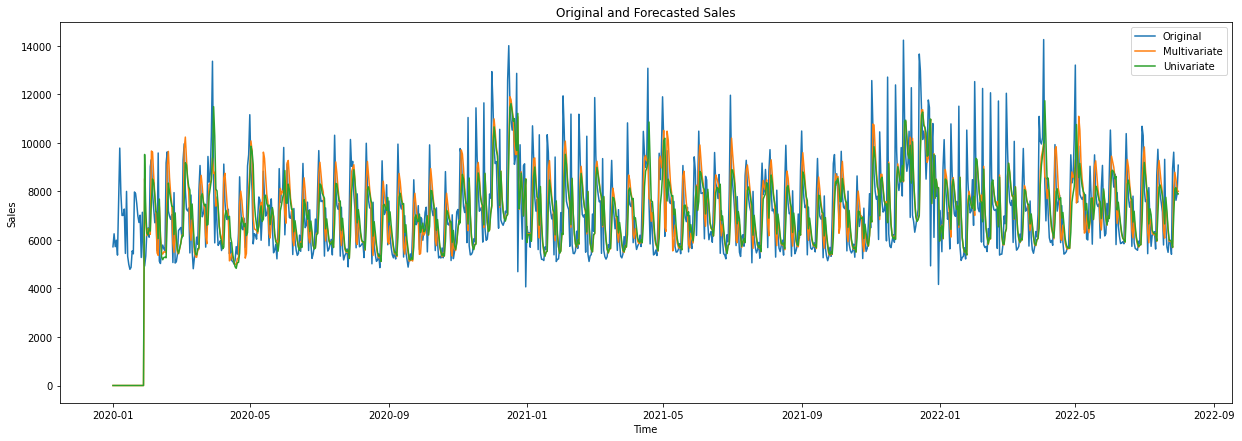

In [87]:
plt.figure(figsize=(21,7))
plt.plot(reg_df.index, reg_df['Sales'], label='Original')
plt.plot(reg_df.index, mv_for, label='Multivariate')
plt.plot(reg_df.index, uv_for, label='Univariate')
plt.title('Original and Forecasted Sales')
plt.xlabel("Time")
plt.ylabel("Sales")
plt.legend()

In [165]:
mv_preds = mv_mod.forecast_path(k=1, X=np.array([[reg_df["Promo"].iloc[-1]]]), nsamps=len(test_dates))
mv_preds


array([[ 8120],
       [ 7559],
       [ 7549],
       [ 8769],
       [ 8513],
       [ 9156],
       [ 9025],
       [ 8549],
       [ 8166],
       [ 9364],
       [ 8490],
       [ 8140],
       [ 8347],
       [ 9072],
       [ 7851],
       [ 8517],
       [ 8970],
       [ 8009],
       [ 8529],
       [ 8480],
       [ 8602],
       [ 8756],
       [ 7860],
       [ 8229],
       [ 8895],
       [ 8506],
       [ 9519],
       [ 7964],
       [ 8107],
       [ 8601],
       [ 8759],
       [ 8834],
       [ 8799],
       [ 8727],
       [ 7896],
       [ 8496],
       [ 8695],
       [ 8706],
       [ 8295],
       [ 9086],
       [10070],
       [ 9468],
       [ 8740],
       [ 8178],
       [ 7897],
       [ 8184],
       [ 8985],
       [ 8463]])

In [166]:
uv_preds = uv_mod.forecast_path(k=1, nsamps=len(test_dates))
uv_preds


array([[8706],
       [8026],
       [8566],
       [8318],
       [8287],
       [8310],
       [8217],
       [8293],
       [8362],
       [8353],
       [7889],
       [8183],
       [8349],
       [7784],
       [8334],
       [8055],
       [8185],
       [8663],
       [8633],
       [8557],
       [8426],
       [8941],
       [8439],
       [8886],
       [8210],
       [8480],
       [8115],
       [8685],
       [9192],
       [8510],
       [8271],
       [8703],
       [8909],
       [8048],
       [8223],
       [8427],
       [8829],
       [7274],
       [7861],
       [8535],
       [8237],
       [8801],
       [8717],
       [8056],
       [8748],
       [8191],
       [8643],
       [8429]])

<AxesSubplot:title={'center':'Univariate and Multivariate Predictions'}, xlabel='Date', ylabel='Sales'>

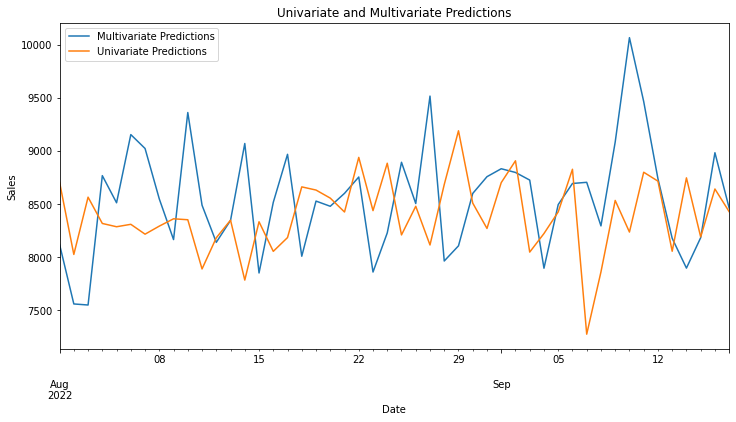

In [188]:
predict_df = pd.DataFrame(columns=['Date', 'Multivariate Predictions', 'Univariate Predictions'])
predict_df['Date'] = test_dates
predict_df['Multivariate Predictions'] = mv_preds
predict_df['Univariate Predictions'] = uv_preds
predict_df = predict_df.set_index('Date')
predict_df.plot(ylabel='Sales', title="Univariate and Multivariate Predictions")